# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os # To join the path to desired directories from current OS
import json
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Check if we can use GPU for this
torch.cuda.empty_cache()
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    device = torch.device("cuda:0")
    print("Training on GPU!")
else:
    device = torch.device("cpu")
    print("Using CPU...")
    
# Constants initializing
num_workers = 0
batch_size = 20
size = 255 # image size
input_size = 224 # Consistent input image size, as required for VGGNet pre-trained network
saved_name = 'VGGNet_19_flowers_augmented.pt' # to save and load our best model later

Training on GPU!


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# Define Training and testing data directories
data_dir = 'flower_data/'

train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/') # for Inference at the end

print(train_dir)

flower_data/train/


In [15]:
# Define transforms for training data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=input_size), # resize all input images to size of 224x224.
    transforms.RandomHorizontalFlip(), # Randomly flip
    transforms.RandomRotation(30), # Rotate from -30 to 30 degrees as min and max range.
    transforms.ToTensor(), # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transforms for validation data
valid_transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.CenterCrop(size=input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=valid_transform)
print('Number of training images: %d\nNumber of validation images: %d' % (len(train_data), len(valid_data)))

# Using the image datasets and the transforms, define the dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size)

Number of training images: 6552
Number of validation images: 818


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [16]:
in_file = 'cat_to_name.json'

with open(in_file, 'r') as file:
    cat_to_name = json.load(file)

# Classes which represent each type of flowers named from 1 to 102, as given from datasets
classes = [cat_to_name[str(i)] for i in range(1, len(cat_to_name) + 1)]
classes2int = { name: index for index, name in enumerate(classes, 1) }

### Data Visualization

In [17]:
# Function to help display given image
def imshow(img):
    img = img / 2 + 0.5 # Un-normalize image
    plt.imshow(np.transpose(img, (1, 2, 0))) # and convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

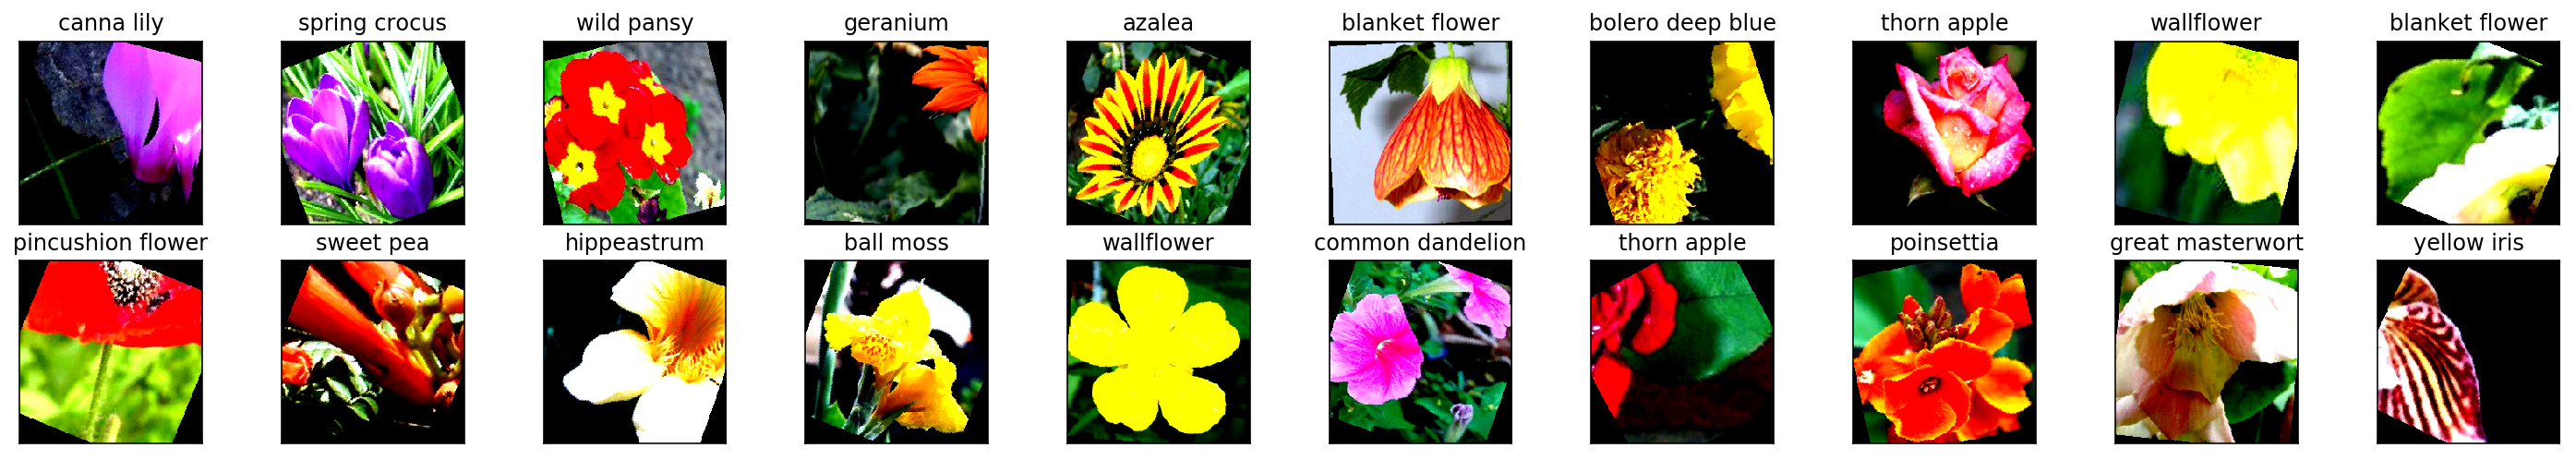

In [18]:
# Let's visualize some sample data by obtaining one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy() # convert to numpy format to display

# Now plot the images in the batch (about 20 of them), along with the corresponding labels
# , and see if there are transformations just like we define above
num_samples = batch_size
fig = plt.figure(figsize=(25, 4))

for index in np.arange(num_samples):
    ax = fig.add_subplot(2, num_samples//2, index+1, xticks=[], yticks=[])
    imshow(images[index]) # and convert from Tensor image

    flower_name = classes[labels[index]]
    ax.set_title(flower_name)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

### Using VGG-19 as a pre-trained network using Transfer Learning

#### Load pre-trained VGG-19

In [8]:
# VGG-19 pre-trained network takes in 224x224 images as input
vgg_19 = models.vgg19(pretrained=True)
print(vgg_19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [9]:
# Next, we need to keep the parameters from the pre-trained network 
# intact during training (freeze them) so we don't backpropagate through them
for param in vgg_19.features.parameters():
    param.requires_grad = False

#### Define our new classifier

In [10]:
# Since we are using a pre-trained network, we can just add or modify the 
# last, fully-connected layer. In details, this layer should takes in the 
# number of inputs produced by the network that are not changing so far, 
# and then provide a number of outputs according to our flower classification goal.

# Now, specify the last layer, with number of inputs taken from the sixth layer inputs
# of VGG-19, which is also the last one in this network
num_inputs = vgg_19.classifier[6].in_features
new_last_layer = nn.Linear(num_inputs, len(classes))
vgg_19.classifier[6] = new_last_layer

# Attach mapping flower's names to its index to our model for later use
vgg_19.class_to_index = classes2int

# Check to see if our new last layer produces as expected
vgg_19.to(device)

print('Num of classifier outputs: {}\n'.format(vgg_19.classifier[6].out_features))

Num of classifier outputs: 102



#### Training classifier - Tracking loss and accuracy

In [11]:
# Before training our classifier, we need to specify our loss funtion and optimizer
# in order to use for training later on.

# Here we use Categorical Cross Entropy loss function for our classification task
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Decent (SGD) with learning rate of 0.01
optimizer = optim.SGD(vgg_19.classifier.parameters(), lr=0.01)

In [12]:
# Number of epochs we need to train our model
epochs = 8
print_every = 100
train_losses, valid_losses = [], []

In [13]:
def validate(model, loader, criterion):
    
    # Initialize lists to monitor test loss and accuracy over 102 types of flowers
    valid_loss = 0.0
    class_correct = list(0.0 for _ in range(len(classes)))
    class_total = list(0.0 for _ in range(len(classes)))

    for image, label in valid_loader:
        # Move to GPU if available
        image, label = image.to(device), label.to(device)

        # Forward pass
        output = model(image)

        # Calculate batch loss
        loss = criterion(output, label)
        valid_loss += loss.item() * image.size(0)

        # Then convert the output probabilities to predicted class
        _, top_class = torch.max(output, 1)
        correct_tensor = top_class.eq(label.view_as(top_class))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        for index in range(label.size(0)):
            target = label[index]
            class_correct[target] += correct[index].item()
            class_total[target] += 1

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    
    accuracy = np.sum(class_correct) / np.sum(class_total) * 100.0

    return valid_loss, accuracy

In [14]:
for epoch in range(1, epochs + 1):
    
    # Here we need to keep track of training and validation loss
    train_loss = 0.0
    
    ##################
    # Training model #
    ##################
    # Set to training mode, just in case because this behavior is by default
    vgg_19.train()
    for index, (image, label) in enumerate(train_loader):

        # Move to GPU, if available
        image, label = image.to(device), label.to(device)
            
        # Clear all the gradient to prepare for next loop time
        optimizer.zero_grad()
        
        # Forward pass: Pass the input into the our model
        output = vgg_19(image)
        
        # Calculate loss for our batch
        loss = criterion(output, label)
        
        # Backward pass: compute the gradient decent so far 
        # of the loss with respect to model parameters
        loss.backward()
        # Update parameters through back-propagation
        optimizer.step()
        
        # Update loss
        train_loss += loss.item()
        
        if index % print_every == (print_every - 1):            
            # Model in inference mode. Hence, dropout is off
            vgg_19.eval()
            
            train_losses.append(train_loss / len(train_loader))
            
            print("Epoch: {}/{}...".format(epoch, epochs),
                  "Training loss: {:.8f}".format(train_loss / len(train_loader)))
            
            train_loss = 0.0
            
            # Turn off gradients for validation to speed up inference
            with torch.no_grad():
                valid_loss, accuracy = validate(vgg_19, valid_loader, criterion)
                print('Valid loss: {:.3f}'.format(valid_loss))
                print("Test Accuracy: {:.3f}%\n".format(accuracy))
                            
            # And make sure dropout and gradients are on for training
            vgg_19.train()

Epoch: 1/8... Training loss: 1.21961653
Valid loss: 62.223
Test Accuracy: 31.296%

Epoch: 1/8... Training loss: 0.89168755
Valid loss: 42.442
Test Accuracy: 50.489%

Epoch: 1/8... Training loss: 0.71114404
Valid loss: 35.246
Test Accuracy: 54.523%

Epoch: 2/8... Training loss: 0.58567588
Valid loss: 27.522
Test Accuracy: 65.037%

Epoch: 2/8... Training loss: 0.53320019
Valid loss: 24.273
Test Accuracy: 69.315%

Epoch: 2/8... Training loss: 0.50251975
Valid loss: 22.822
Test Accuracy: 69.315%

Epoch: 3/8... Training loss: 0.45745209
Valid loss: 19.297
Test Accuracy: 75.306%

Epoch: 3/8... Training loss: 0.45176736
Valid loss: 18.168
Test Accuracy: 74.817%

Epoch: 3/8... Training loss: 0.46010026
Valid loss: 16.943
Test Accuracy: 77.262%

Epoch: 4/8... Training loss: 0.38981786
Valid loss: 17.174
Test Accuracy: 77.384%

Epoch: 4/8... Training loss: 0.40126961
Valid loss: 14.873
Test Accuracy: 81.296%

Epoch: 4/8... Training loss: 0.37902984
Valid loss: 14.551
Test Accuracy: 80.685%

Epoc

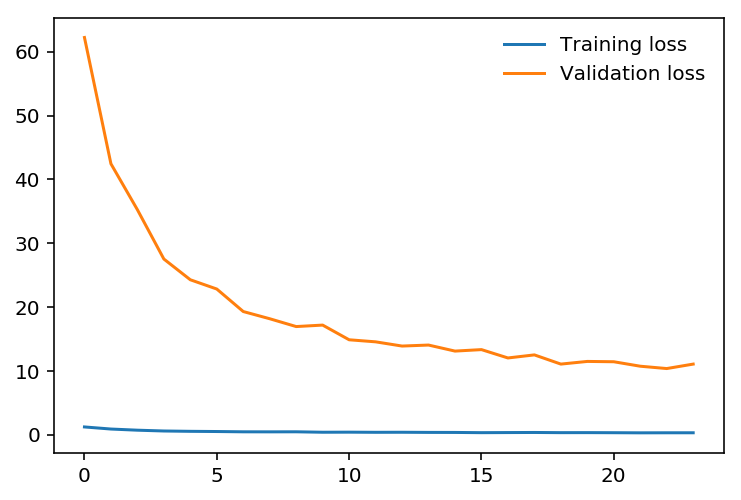

In [15]:
# Plot the result out for visualization
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')

plt.legend(frameon=False)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
checkpoint = {
    'input_size': 25088,
    'output_size': len(classes),
    'state_dict': vgg_19.state_dict()
}

# Save the result
torch.save(checkpoint, saved_name)        

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [40]:
# Function that loads a checkpoint and rebuilds the model
import torch
from torchvision import models

def load_rebuild_model(submission_checkpoint):
    checkpoint = torch.load(submission_checkpoint)
    
    loaded_model = models.vgg19(pretrained=False)
    for param in loaded_model.parameters():
        param.requires_grad = False
        
    num_inputs = loaded_model.classifier[6].in_features
    new_last_layer = nn.Linear(num_inputs, checkpoint['output_size'])
    loaded_model.classifier[6] = new_last_layer
    
    loaded_model.load_state_dict(checkpoint['state_dict'])
    
    return loaded_model

In [43]:
loaded_model = models.vgg19(pretrained=True)

In [48]:
# Load your model to this variable
submission_checkpoint = "VGGNet_19_flowers_augmented.pt"
loaded_model = load_checkpoint(submission_checkpoint)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [45]:
def predict(images, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''    
    model.cpu() # CPU is expected

    with torch.no_grad():
        output = model(images)
    
    # Predict the class from an image file
    top_p, top_pred = torch.max(output, 1)
    preds = np.squeeze(top_pred.numpy()) if not train_on_gpu else np.squeeze(top_pred.cpu().numpy())

    return top_p, preds

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [46]:
# Predict labels for different test images
images, _ = next(iter(test_loader))
probabilities, preds = predict(images, loaded_model)

print(probabilities)
print(preds)

tensor([ 8.1667, 10.5755, 19.8662])
[74 75 79]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


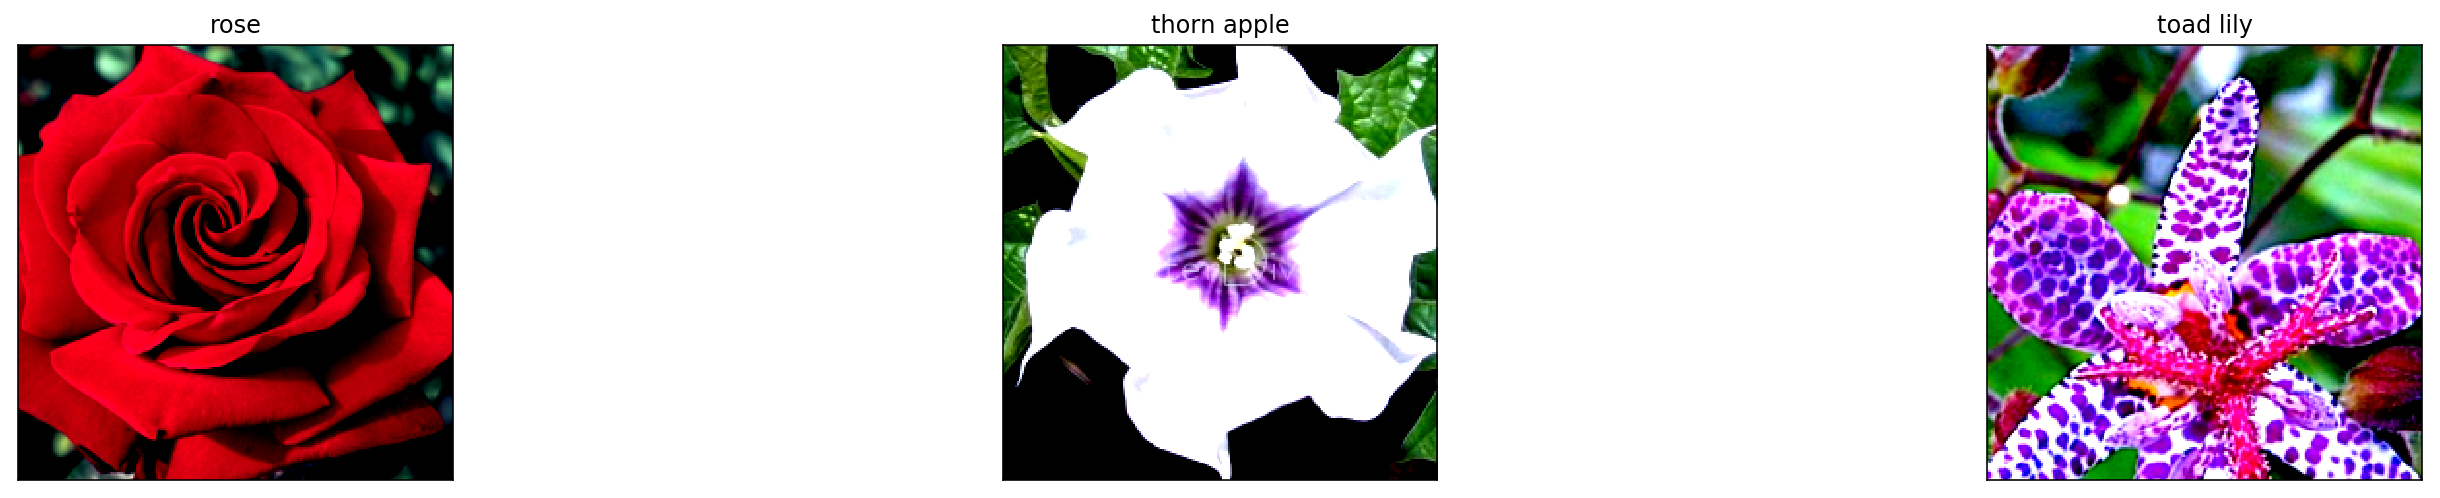

In [47]:
fig = plt.figure(figsize=(25, 4))

for index, pred in enumerate(preds):
    pred_label = classes[int(pred)-1]

    ax = fig.add_subplot(1, len(preds), index+1, xticks=[], yticks=[])
    imshow(images[index])
          
    ax.set_title(pred_label)